# Task 2: Measuring Fairness

__Note__: Some graphs created with `plotly` may not be normally visualized in GitHub due to lack of support of certain affiliated packages. Please navigate to the `../results/` directory or download the notebook to run locally for better experience.

## Import libraries and functions

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# model: choose RF for its overall good performance
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# constants
from const import *

# udfs
from utils import *

## Load Dataset

In [2]:
labeled_df_raw = pd.read_csv('../' + LABELED_DATA_PATH).drop('Unnamed: 0', axis=1)
labeled_y, labeled_X = labeled_df_raw['Risk'], labeled_df_raw.drop('Risk', axis=1)

## Split Dataset into Training and Validation Subsets

In [3]:
train_X, val_X, train_y, val_y = train_test_split(labeled_X, labeled_y, test_size=VAL_RATIO, random_state=RANDOM_SEED)

In [4]:
val_full = pd.merge(val_X, val_y, left_index=True, right_index=True)

## Baseline Model: With All Attributes Included

Since group fairness and separation are both based on a model trained on the full corpus with all attributes incorporated, it is plausible to firstly train it here and reuse the results for convenience and clearer reference.

In [5]:
val_full, baseline = anti_classification(
    'None', RandomForestClassifier(), 'RF', train_X, train_y, val_full, True, True
)

In [6]:
# obtain the bins / boxes for subgroups
min_age, max_age = 10 * int(val_full['Age'].min() / 10), 10 * math.ceil(val_full['Age'].max() / 10)
age_group_count = (max_age - min_age) // 10
female, male = 'female', 'male'

In [7]:
prob_col = 'Risk_prob(protected=None, model=RF)'
pred_col = 'Risk_pred(protected=None, model=RF)'
true_col = 'Risk'

In [8]:
# Confusion Matrix on Full Results
print("\n\nConfusion Matrix: Nothing Protected (Baseline)\n")
_ = print_confusion_matrix(confusion_matrix(val_full[true_col], val_full[[pred_col]]))



Confusion Matrix: Nothing Protected (Baseline)

------------- Confusion Matrix (Count) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                 111                 23
Factually Bad                   38                 28
-----------------------------------------------------


------------- Confusion Matrix (Ratio) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good               0.555              0.115
Factually Bad                0.19               0.14
-----------------------------------------------------


## Measuring Fairness
### 1. Anti-Classification

For each protected attribute in `attrs = ('Age', 'Sex')`, a model will be trained totally agnostic of this attribute, while the results will be visualized against its distribution.

#### 1.1 Protected Attribute: Age

In [9]:
protected_attr_0 = 'Age'
val_full = anti_classification(
    protected_attr_0, RandomForestClassifier(), 'RF', train_X, train_y, val_full
)

##### a. Distribution of Predictions by New Model

In [10]:
# visualize the results
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk_pred(protected=Age, model=RF)']=='good']['Age'],
    marker_color='#EB89B5',
    opacity=0.75,
    name='prediction="good"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk']=='good']['Age'],
    marker_color='#FDE18A',
    opacity=0.75,
    name='groundtruth="good"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk_pred(protected=Age, model=RF)']=='bad']['Age'],
    marker_color='#330C73',
    opacity=0.75,
    name='prediction="bad"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk']=='bad']['Age'],
    marker_color='#9591F3',
    opacity=0.75,
    name='groudtruth="bad"'
))
fig.update_layout(
    title_text='Distribution of Good/Bad Credit along with Age',
    xaxis_title='Age',
    yaxis_title='Count'
)
# fig.write_image('../results/anti-classification-age.png', scale=5)
fig.show()

##### b. Confusion Matrix (New Model)

In [11]:
# confusion matrix
print("\n\nConfusion Matrix: Age Protected\n")
_ = print_confusion_matrix(confusion_matrix(val_full['Risk'], val_full['Risk_pred(protected=Age, model=RF)']))



Confusion Matrix: Age Protected

------------- Confusion Matrix (Count) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                 111                 23
Factually Bad                   36                 30
-----------------------------------------------------


------------- Confusion Matrix (Ratio) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good               0.555              0.115
Factually Bad                0.18               0.15
-----------------------------------------------------


##### c. Percentage of Changes with Perturbed Ages

In [12]:
# perturb the original dataset 
val_full_age_perturbed = val_full.copy()
val_full_age_perturbed['Age'] = val_full_age_perturbed.apply(lambda x: perturb_attr(x, 'Age', [int(i) for i in range(min_age, max_age + 1)]), axis=1)

# predict the label based on new perturbed ages
pred_col_age_perturbed = 'Risk_pred_with_perturbed_age'
val_full_age_perturbed[pred_col_age_perturbed] = baseline.predict(dummify(val_full_age_perturbed[labeled_X.columns]))

# obtain the percentage of changes
percentage_of_change_age_pertubed = 1 - accuracy_score(
    val_full_age_perturbed[pred_col],
    val_full_age_perturbed[pred_col_age_perturbed]
)
print(f"{percentage_of_change_age_pertubed * 100:.2f}% of validation samples are diffently "
      f"predicted with a perturbed age.")

11.50% of validation samples are diffently predicted with a perturbed age.


### 1.2 Protected Attribute: Sex

In [13]:
protected_attr_1 = 'Sex'
val_full = anti_classification(
    protected_attr_1, RandomForestClassifier(), 'RF', train_X, train_y, val_full
)

##### a. Distribution of Predictions by New Model

In [14]:
# visualize the results
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk_pred(protected=Sex, model=RF)']=='good']['Sex'],
    marker_color='#EB89B5',
    opacity=0.75,
    name='prediction="good"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk']=='good']['Sex'],
    marker_color='#FDE18A',
    opacity=0.75,
    name='groundtruth="good"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk_pred(protected=Sex, model=RF)']=='bad']['Sex'],
    marker_color='#330C73',
    opacity=0.75,
    name='prediction="bad"'
))
fig.add_trace(go.Histogram(
    x=val_full[val_full['Risk']=='bad']['Sex'],
    marker_color='#9591F3',
    opacity=0.75,
    name='groudtruth="bad"'
))
fig.update_layout(
    title_text='Distribution of Good/Bad Credit along with Sex',
    xaxis_title='Sex',
    yaxis_title='Count'
)
# fig.write_image('../results/anti-classification-sex.png', scale=5)
fig.show()

##### b. Confusion Matrix (New Model)

In [15]:
# confusion matrix
print("\n\nConfusion Matrix: Gender Protected\n")
_ = print_confusion_matrix(confusion_matrix(val_full['Risk'], val_full['Risk_pred(protected=Sex, model=RF)']))



Confusion Matrix: Gender Protected

------------- Confusion Matrix (Count) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                 112                 22
Factually Bad                   36                 30
-----------------------------------------------------


------------- Confusion Matrix (Ratio) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                0.56               0.11
Factually Bad                 0.18               0.15
-----------------------------------------------------


##### c. Percentage of Changes with Perturbed Gender

In [16]:
# perturb the original dataset 
val_full_sex_perturbed = val_full.copy()
val_full_sex_perturbed['Sex'] = val_full_sex_perturbed.apply(lambda x: perturb_attr(x, 'Sex', [female, male]), axis=1)

# predict the label based on new perturbed ages
pred_col_sex_perturbed = 'Risk_pred_with_perturbed_gender'
val_full_sex_perturbed[pred_col_sex_perturbed] = baseline.predict(dummify(val_full_sex_perturbed[labeled_X.columns]))

# obtain the percentage of changes
percentage_of_change_sex_pertubed = 1 - accuracy_score(
    val_full_sex_perturbed[pred_col],
    val_full_sex_perturbed[pred_col_sex_perturbed]
)
print(f"{percentage_of_change_sex_pertubed * 100:.2f}% of validation samples are diffently "
      f"predicted with a perturbed gender.")

10.50% of validation samples are diffently predicted with a perturbed gender.


### 2. Group Fairness

__NOTE:__ Since the model used for both _group fairness_ and _separation_ is the same, trained on all features without omission, it is feasible to use the previous baseline model.

In [17]:
focus_list = [0.1 * int(i) for i in range(0, 11)]
age_dict, sex_dict = dict(), dict()

for i in focus_list:
    age_dict[i], sex_dict[i] = dict(), dict()
    for gender in (female, male):
        sex_dict[i][gender] = get_threshold('Sex', gender, val_full, prob_col, i)
    for j in range(age_group_count):
        left, right = min_age + 10 * j, min_age + 10 * (j + 1)
        key_name = '%d-%d' % (left, right)
        age_dict[i][key_name] = get_threshold('Age', left, val_full, prob_col, i, right)

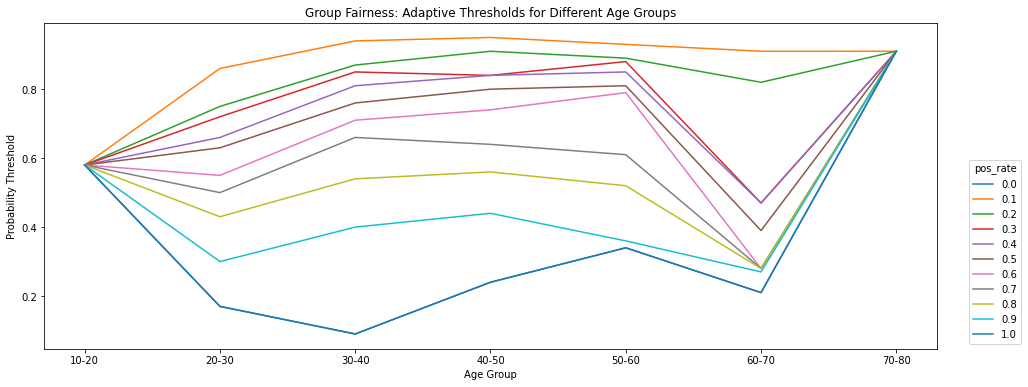

In [18]:
# plot for Age
plt.figure(figsize=(16, 6))
plt.title('Group Fairness: Adaptive Thresholds for Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Probability Threshold')
for i in focus_list:
    plt.plot(age_dict[i].keys(), age_dict[i].values())
plt.legend([f"{f:.1f}" for f in focus_list], title='pos_rate', loc='lower right', bbox_to_anchor=(1.1, 0))
# plt.savefig('../results/group-fairness-age.png', dpi=128)
plt.show()


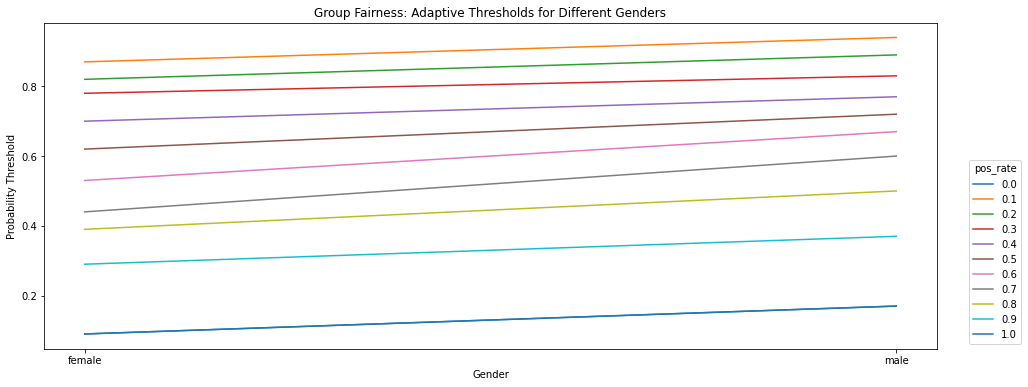

In [19]:
# plot for Sex
plt.figure(figsize=(16, 6))
plt.title('Group Fairness: Adaptive Thresholds for Different Genders')
plt.xlabel('Gender')
plt.ylabel('Probability Threshold')
for i in focus_list:
    plt.plot(sex_dict[i].keys(), sex_dict[i].values())
plt.legend([f"{f:.1f}" for f in focus_list], title='pos_rate', loc='lower right', bbox_to_anchor=(1.1, 0))
# plt.savefig('../results/group-fairness-sex.png', dpi=128)
plt.show()


### 3. Seperation

In [20]:
# separation for Sex
tpr_sex, fpr_sex, fnr_sex, tnr_sex  = dict(), dict(), dict(), dict()
for gender in (female, male):
    print("\n\n\n*****************************************************")
    print(f"******* Separation by Sex: Now for {gender.upper():<10} *******")
    tpr_sex[gender], fpr_sex[gender], fnr_sex[gender], tnr_sex[gender] = seperate_by_attr('Sex', gender, val_full, true_col, pred_col)
    print("*****************************************************\n\n\n")




*****************************************************
******* Separation by Sex: Now for FEMALE     *******
------------- Confusion Matrix (Count) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                  14                 13
Factually Bad                    7                 26
-----------------------------------------------------


------------- Confusion Matrix (Ratio) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good              0.2333             0.2167
Factually Bad               0.1167             0.4333
-----------------------------------------------------
*****************************************************






*****************************************************
******* Separation by Sex: Now for MALE       *******
------------- Confusion Matrix (Count) --------------
                 

In [21]:
# visualize the results
fig = go.Figure()
fig.add_trace(go.Bar(
    x=list(tpr_sex.keys()),
    y=list(tpr_sex.values()),
    marker_color='#F3A291',
    opacity=0.75,
    name='true positive rate'
))
fig.add_trace(go.Bar(
    x=list(fpr_sex.keys()),
    y=list(fpr_sex.values()),
    marker_color='#F3CA91',
    opacity=0.75,
    name='false positive rate'
))
fig.add_trace(go.Bar(
    x=list(fnr_sex.keys()),
    y=list(fnr_sex.values()),
    marker_color='#CAF391',
    opacity=0.75,
    name='false negative rate'
))
fig.add_trace(go.Bar(
    x=list(tnr_sex.keys()),
    y=list(tnr_sex.values()),
    marker_color='#91F3D1',
    opacity=0.75,
    name='true negative rate'
))
fig.update_layout(
    title_text='Metrics within Confusion Matrix w.r.t. Gender Differences',
    xaxis_title='Sex',
    yaxis_title='Rate'
)
# fig.write_image('../results/separation-sex.png', scale=2)
fig.show()

In [22]:
# separation for Age
tpr_age, fpr_age, fnr_age, tnr_age  = dict(), dict(), dict(), dict()
for i in range(age_group_count):
    left, right = min_age + 10 * i, min_age + 10 * (i + 1)
    key_name = '%d-%d' % (left, right)
    print("\n\n\n*****************************************************")
    print(f"**** Separation by Age:  Now for {key_name} years old ****")
    tpr_age[key_name], fpr_age[key_name], fnr_age[key_name], tnr_age[key_name]= seperate_by_attr('Age', left, val_full, true_col, pred_col, right)
    print("*****************************************************\n\n\n")




*****************************************************
**** Separation by Age:  Now for 10-20 years old ****
------------- Confusion Matrix (Count) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                   0                  0
Factually Bad                    0                  1
-----------------------------------------------------


------------- Confusion Matrix (Ratio) --------------
                  Predictably Good    Predictably Bad
--------------  ------------------  -----------------
Factually Good                   0                  0
Factually Bad                    0                  1
-----------------------------------------------------
*****************************************************






*****************************************************
**** Separation by Age:  Now for 20-30 years old ****
------------- Confusion Matrix (Count) --------------
                 

In [23]:
# visualize the results
fig = go.Figure()
fig.add_trace(go.Bar(
    x=list(tpr_age.keys()),
    y=list(tpr_age.values()),
    marker_color='#F3A291',
    opacity=0.75,
    name='true positive rate'
))
fig.add_trace(go.Bar(
    x=list(fpr_age.keys()),
    y=list(fpr_age.values()),
    marker_color='#F3CA91',
    opacity=0.75,
    name='false positive rate'
))
fig.add_trace(go.Bar(
    x=list(fnr_age.keys()),
    y=list(fnr_age.values()),
    marker_color='#CAF391',
    opacity=0.75,
    name='false negative rate'
))
fig.add_trace(go.Bar(
    x=list(tnr_age.keys()),
    y=list(tnr_age.values()),
    marker_color='#91F3D1',
    opacity=0.75,
    name='true negative rate'
))
fig.update_layout(
    title_text='Metrics within Confusion Matrix w.r.t. Age Differences',
    xaxis_title='Age',
    yaxis_title='Rate'
)
# fig.write_image('../results/separation-age.png', scale=2)
fig.show()